In [6]:
import matplotlib as mpl
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt

# 在Windows系统中使用微软雅黑字体（如果有）
try:
    font_paths = fm.findSystemFonts(fontpaths=None, fontext='ttf')
    # 查找Windows中的微软雅黑字体
    msyh_fonts = [f for f in font_paths if 'msyh' in f.lower() or 'microsoftyahei' in f.lower()]
    if msyh_fonts:
        plt.rcParams['font.family'] = ['Microsoft YaHei']
    else:
        # 如果没有找到微软雅黑，尝试使用SimHei或其他中文字体
        plt.rcParams['font.sans-serif'] = ['SimHei', 'SimSun', 'NSimSun', 'FangSong', 'KaiTi']
except:
    # 如果上述方法失败，尝试直接设置
    plt.rcParams['font.sans-serif'] = ['SimHei', 'DejaVu Sans']

# 解决负号显示问题
plt.rcParams['axes.unicode_minus'] = False

# 显示当前字体设置
print("当前使用的字体设置:", mpl.rcParams['font.family'])
print("当前支持的中文字体:", plt.rcParams.get('font.sans-serif'))

当前使用的字体设置: ['Microsoft YaHei']
当前支持的中文字体: ['DejaVu Sans', 'Bitstream Vera Sans', 'Computer Modern Sans Serif', 'Lucida Grande', 'Verdana', 'Geneva', 'Lucid', 'Arial', 'Helvetica', 'Avant Garde', 'sans-serif']


In [7]:
import matplotlib.pyplot as plt
import numpy as np
import prettytable

# 进程状态枚举
class ProcessState:
    READY = "就绪"
    RUNNING = "运行中"
    BLOCKED = "阻塞"
    FINISHED = "已完成"

# 进程控制块(PCB)
class PCB:
    def __init__(self, pid, name, arrive_time, burst_time, priority=0):
        self.pid = pid                  # 进程ID
        self.name = name                # 进程名称
        self.state = ProcessState.READY # 进程状态
        self.priority = priority        # 优先级(数值越小优先级越高)
        self.arrive_time = arrive_time  # 到达时间
        self.burst_time = burst_time    # 所需执行时间
        self.remaining_time = burst_time# 剩余执行时间
        self.start_time = -1            # 开始执行时间
        self.finish_time = -1           # 完成时间
        
    def __lt__(self, other):
        # 用于优先队列比较，默认按到达时间排序
        return self.arrive_time < other.arrive_time
        
    def calculate_turnaround_time(self):
        """计算周转时间"""
        return self.finish_time - self.arrive_time
        
    def calculate_weighted_turnaround_time(self):
        """计算带权周转时间"""
        return self.calculate_turnaround_time() / self.burst_time

In [8]:
class Scheduler:
    def __init__(self, processes=None):
        self.processes = processes if processes else []
        self.ready_queue = []
        self.finished_processes = []
        self.current_time = 0
        self.execution_log = []  # 添加执行日志记录
        
    def add_process(self, process):
        """添加进程到待调度列表"""
        self.processes.append(process)
        
    def reset(self):
        """重置所有进程状态"""
        for process in self.processes:
            process.state = ProcessState.READY
            process.remaining_time = process.burst_time
            process.start_time = -1
            process.finish_time = -1
        self.ready_queue = []
        self.finished_processes = []
        self.current_time = 0
        self.execution_log = []  # 重置执行日志
    
    # 添加记录执行过程的辅助方法
    def _log_execution(self, process, start_time, end_time, status="执行"):
        """记录进程执行日志"""
        self.execution_log.append({
            "pid": process.pid,
            "name": process.name,
            "start_time": start_time,
            "end_time": end_time,
            "status": status
        })
    
    def fcfs(self):
        """先来先服务调度算法"""
        self.reset()
        # 按到达时间排序
        sorted_processes = sorted(self.processes, key=lambda p: p.arrive_time)
        
        self.current_time = 0
        for process in sorted_processes:
            # 如果进程还未到达，CPU空闲等待
            if process.arrive_time > self.current_time:
                # 记录CPU空闲时间
                self._log_execution(None, self.current_time, process.arrive_time, "空闲")
                self.current_time = process.arrive_time
            
            # 执行进程
            process.state = ProcessState.RUNNING
            process.start_time = self.current_time
            start_time = self.current_time
            self.current_time += process.burst_time
            process.finish_time = self.current_time
            process.state = ProcessState.FINISHED
            self.finished_processes.append(process)
            
            # 记录进程执行
            self._log_execution(process, start_time, self.current_time)
            
        return self._calculate_statistics()
    
    def sjf(self):
        """短作业优先调度算法（非抢占式）"""
        self.reset()
        
        remaining_processes = sorted(self.processes, key=lambda p: p.arrive_time)
        
        self.current_time = 0
        while remaining_processes or self.ready_queue:
            # 更新就绪队列
            while remaining_processes and remaining_processes[0].arrive_time <= self.current_time:
                process = remaining_processes.pop(0)
                self.ready_queue.append(process)
            
            # 如果就绪队列为空，直接跳到下一个到达的进程
            if not self.ready_queue and remaining_processes:
                idle_start = self.current_time
                self.current_time = remaining_processes[0].arrive_time
                # 记录CPU空闲时间
                self._log_execution(None, idle_start, self.current_time, "空闲")
                continue
                
            # 选择最短作业
            self.ready_queue.sort(key=lambda p: p.burst_time)
            process = self.ready_queue.pop(0)
            
            # 执行进程
            process.state = ProcessState.RUNNING
            process.start_time = self.current_time
            start_time = self.current_time
            self.current_time += process.burst_time
            process.finish_time = self.current_time
            process.state = ProcessState.FINISHED
            self.finished_processes.append(process)
            
            # 记录进程执行
            self._log_execution(process, start_time, self.current_time)
            
        return self._calculate_statistics()
    
    def priority(self):
        """优先级调度算法（非抢占式）"""
        self.reset()
        
        remaining_processes = sorted(self.processes, key=lambda p: p.arrive_time)
        
        self.current_time = 0
        while remaining_processes or self.ready_queue:
            # 更新就绪队列
            while remaining_processes and remaining_processes[0].arrive_time <= self.current_time:
                process = remaining_processes.pop(0)
                self.ready_queue.append(process)
            
            # 如果就绪队列为空，直接跳到下一个到达的进程
            if not self.ready_queue and remaining_processes:
                idle_start = self.current_time
                self.current_time = remaining_processes[0].arrive_time
                # 记录CPU空闲时间
                self._log_execution(None, idle_start, self.current_time, "空闲")
                continue
                
            # 选择优先级最高的作业
            self.ready_queue.sort(key=lambda p: p.priority)
            process = self.ready_queue.pop(0)
            
            # 执行进程
            process.state = ProcessState.RUNNING
            process.start_time = self.current_time
            start_time = self.current_time
            self.current_time += process.burst_time
            process.finish_time = self.current_time
            process.state = ProcessState.FINISHED
            self.finished_processes.append(process)
            
            # 记录进程执行
            self._log_execution(process, start_time, self.current_time)
            
        return self._calculate_statistics()
    
    def round_robin(self, time_slice):
        """时间片轮转调度算法"""
        self.reset()
        
        remaining_processes = sorted(self.processes, key=lambda p: p.arrive_time)
        
        self.current_time = 0
        while remaining_processes or self.ready_queue:
            # 更新就绪队列
            while remaining_processes and remaining_processes[0].arrive_time <= self.current_time:
                process = remaining_processes.pop(0)
                self.ready_queue.append(process)
            
            # 如果就绪队列为空，直接跳到下一个到达的进程
            if not self.ready_queue and remaining_processes:
                idle_start = self.current_time
                self.current_time = remaining_processes[0].arrive_time
                # 记录CPU空闲时间
                self._log_execution(None, idle_start, self.current_time, "空闲")
                continue
                
            # 取出队首进程
            process = self.ready_queue.pop(0)
            
            # 记录开始时间
            if process.start_time == -1:
                process.start_time = self.current_time
                
            # 执行时间片
            execute_time = min(time_slice, process.remaining_time)
            start_time = self.current_time
            self.current_time += execute_time
            process.remaining_time -= execute_time
            
            # 记录本次时间片执行
            self._log_execution(process, start_time, self.current_time, 
                                f"执行(剩余:{process.remaining_time})")
            
            # 更新就绪队列（将新到达的进程加入队列）
            while remaining_processes and remaining_processes[0].arrive_time <= self.current_time:
                new_process = remaining_processes.pop(0)
                self.ready_queue.append(new_process)
            
            # 判断进程是否完成
            if process.remaining_time == 0:
                process.finish_time = self.current_time
                process.state = ProcessState.FINISHED
                self.finished_processes.append(process)
            else:
                # 重新加入就绪队列
                self.ready_queue.append(process)
            
        return self._calculate_statistics()
    
    def _calculate_statistics(self):
        """计算统计信息"""
        turnaround_times = [p.calculate_turnaround_time() for p in self.finished_processes]
        weighted_turnaround_times = [p.calculate_weighted_turnaround_time() for p in self.finished_processes]
        
        avg_turnaround = sum(turnaround_times) / len(self.finished_processes)
        avg_weighted_turnaround = sum(weighted_turnaround_times) / len(self.finished_processes)
        
        # 返回统计结果
        return {
            "processes": self.finished_processes,
            "turnaround_times": turnaround_times,
            "weighted_turnaround_times": weighted_turnaround_times,
            "avg_turnaround": avg_turnaround,
            "avg_weighted_turnaround": avg_weighted_turnaround
        }

In [9]:
def plot_gantt_chart(algorithm_name, execution_log):
    """绘制甘特图显示调度过程"""
    fig, ax = plt.subplots(figsize=(14, 6))
    
    # 准备颜色映射
    process_colors = plt.cm.tab10(np.linspace(0, 1, 10))
    
    # 为进程分配唯一颜色
    pid_to_color = {}
    current_color_idx = 0
    
    # 添加图例条目
    legend_items = []
    
    y_pos = 0  # 只有一行
    
    for entry in execution_log:
        start = entry["start_time"]
        end = entry["end_time"]
        width = end - start
        
        if entry["pid"] is None:  # 空闲时间
            ax.barh(y_pos, width, left=start, height=0.8, 
                   color='lightgrey', edgecolor='black', alpha=0.5)
            ax.text(start + width/2, y_pos, "空闲", 
                   ha='center', va='center', color='black', fontsize=8)
        else:
            # 为新进程分配颜色
            if entry["pid"] not in pid_to_color:
                pid_to_color[entry["pid"]] = process_colors[current_color_idx % len(process_colors)]
                current_color_idx += 1
                legend_items.append(plt.Rectangle((0, 0), 1, 1, 
                                   color=pid_to_color[entry["pid"]], 
                                   label=f"{entry['name']} (PID:{entry['pid']})"))
            
            # 绘制进程执行条
            ax.barh(y_pos, width, left=start, height=0.8, 
                   color=pid_to_color[entry["pid"]], edgecolor='black')
            
            # 添加时间标签
            time_text = f"{start}-{end}"
            ax.text(start + width/2, y_pos, f"{entry['name']}\n{time_text}", 
                   ha='center', va='center', color='black', fontsize=8)
    
    # 设置Y轴
    ax.set_yticks([])
    ax.set_xlabel('时间')
    ax.set_title(f'{algorithm_name} 调度过程')
    
    # 添加图例
    ax.legend(handles=legend_items, loc='upper center', 
             bbox_to_anchor=(0.5, -0.1), ncol=5)
    
    plt.tight_layout()
    plt.show()
    
def print_detailed_results(algorithm_name, result, execution_log):
    """打印详细的调度结果"""
    print(f"\n--- {algorithm_name} 调度结果 ---")
    
    # 创建进程表
    table = prettytable.PrettyTable()
    table.field_names = [
        '进程ID', '进程名', '到达时间', '服务时间',
        '开始时间', '完成时间', '周转时间', '带权周转时间'
    ]
    
    for i, p in enumerate(result["processes"]):
        table.add_row([
            p.pid, p.name, p.arrive_time, p.burst_time, 
            p.start_time, p.finish_time,
            result["turnaround_times"][i],
            f"{result['weighted_turnaround_times'][i]:.2f}"
        ])
    
    print(table)
    print(f"\n平均周转时间: {result['avg_turnaround']:.2f}")
    print(f"平均带权周转时间: {result['avg_weighted_turnaround']:.2f}")
    
    # 显示执行过程表格
    print("\n调度执行过程:")
    log_table = prettytable.PrettyTable()
    log_table.field_names = ['进程名', '进程ID', '开始时间', '结束时间', '执行时长']
    
    for entry in execution_log:
        if entry["pid"] is None:
            log_table.add_row(["--空闲--", "-", entry["start_time"], 
                              entry["end_time"], entry["end_time"] - entry["start_time"]])
        else:
            log_table.add_row([entry["name"], entry["pid"], entry["start_time"], 
                              entry["end_time"], entry["end_time"] - entry["start_time"]])
    
    print(log_table)

def visualize_results(results_dict):
    """可视化不同调度算法的结果比较"""
    algorithms = list(results_dict.keys())
    avg_turnaround = [results_dict[alg]["avg_turnaround"] for alg in algorithms]
    avg_weighted = [results_dict[alg]["avg_weighted_turnaround"] for alg in algorithms]
    
    x = np.arange(len(algorithms))
    width = 0.35
    
    fig, ax = plt.subplots(figsize=(12, 6))
    bar1 = ax.bar(x - width/2, avg_turnaround, width, label='平均周转时间')
    bar2 = ax.bar(x + width/2, avg_weighted, width, label='平均带权周转时间')
    
    ax.set_ylabel('时间')
    ax.set_title('不同进程调度算法性能比较')
    ax.set_xticks(x)
    ax.set_xticklabels(algorithms)
    ax.legend()
    
    # 在柱状图上添加数值标签
    for bar in [bar1, bar2]:
        for rect in bar:
            height = rect.get_height()
            ax.annotate(f'{height:.2f}',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()


--- FCFS (先来先服务) 调度结果 ---
+--------+--------+----------+----------+----------+----------+----------+--------------+
| 进程ID | 进程名 | 到达时间 | 服务时间 | 开始时间 | 完成时间 | 周转时间 | 带权周转时间 |
+--------+--------+----------+----------+----------+----------+----------+--------------+
|   1    | 进程1  |    0     |    8     |    0     |    8     |    8     |     1.00     |
|   2    | 进程2  |    1     |    4     |    8     |    12    |    11    |     2.75     |
|   3    | 进程3  |    2     |    9     |    12    |    21    |    19    |     2.11     |
|   4    | 进程4  |    3     |    5     |    21    |    26    |    23    |     4.60     |
|   5    | 进程5  |    4     |    2     |    26    |    28    |    24    |    12.00     |
|   6    | 进程6  |    5     |    3     |    28    |    31    |    26    |     8.67     |
|   7    | 进程7  |    6     |    6     |    31    |    37    |    31    |     5.17     |
|   8    | 进程8  |    7     |    1     |    37    |    38    |    31    |    31.00     |
|   9    | 进程9  |    8     |  

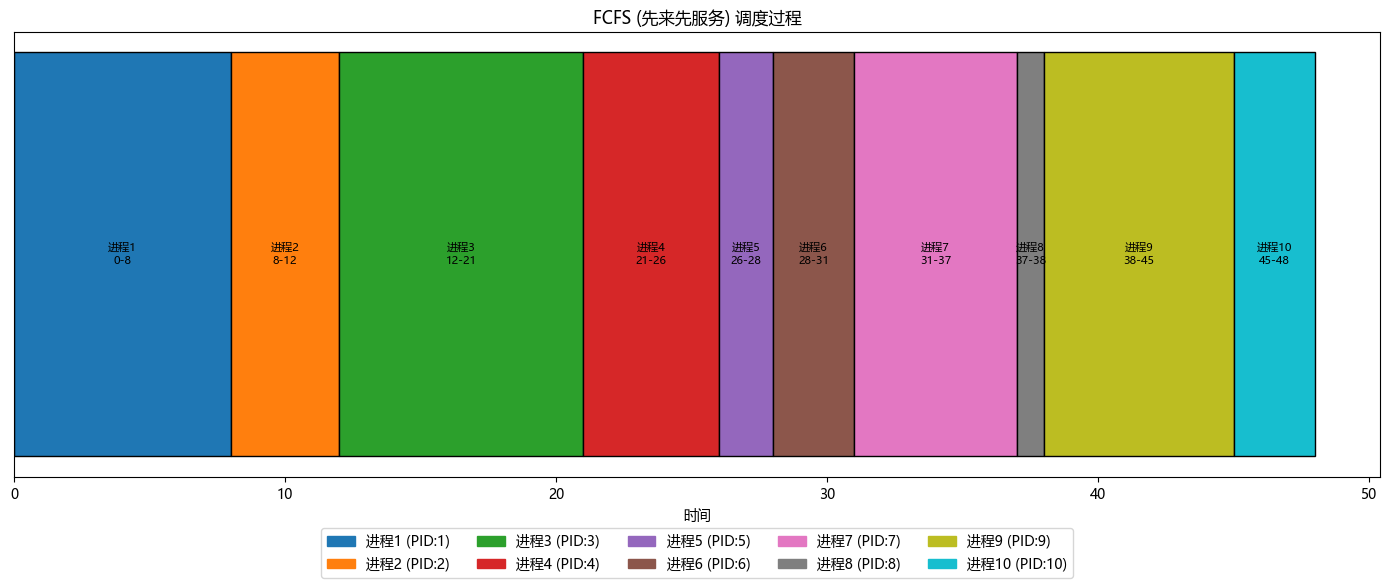


--- SJF (短作业优先) 调度结果 ---
+--------+--------+----------+----------+----------+----------+----------+--------------+
| 进程ID | 进程名 | 到达时间 | 服务时间 | 开始时间 | 完成时间 | 周转时间 | 带权周转时间 |
+--------+--------+----------+----------+----------+----------+----------+--------------+
|   1    | 进程1  |    0     |    8     |    0     |    8     |    8     |     1.00     |
|   8    | 进程8  |    7     |    1     |    8     |    9     |    2     |     2.00     |
|   5    | 进程5  |    4     |    2     |    9     |    11    |    7     |     3.50     |
|   6    | 进程6  |    5     |    3     |    11    |    14    |    9     |     3.00     |
|   10   | 进程10 |    9     |    3     |    14    |    17    |    8     |     2.67     |
|   2    | 进程2  |    1     |    4     |    17    |    21    |    20    |     5.00     |
|   4    | 进程4  |    3     |    5     |    21    |    26    |    23    |     4.60     |
|   7    | 进程7  |    6     |    6     |    26    |    32    |    26    |     4.33     |
|   9    | 进程9  |    8     |   

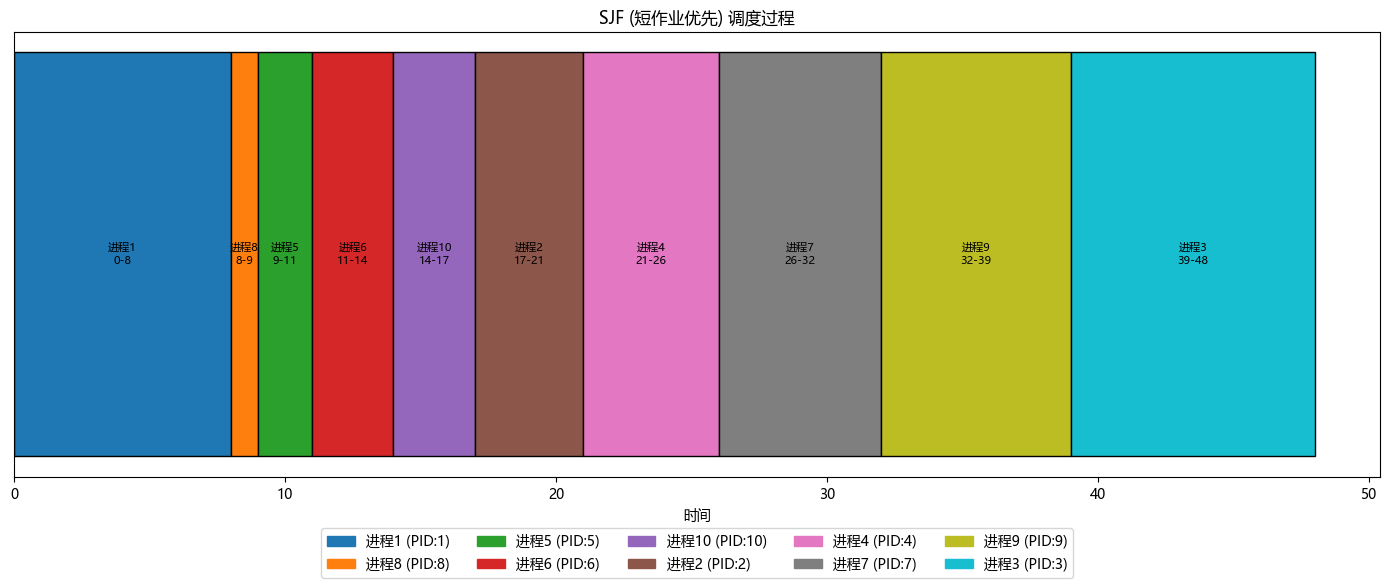


--- Priority (优先级调度) 调度结果 ---
+--------+--------+----------+----------+----------+----------+----------+--------------+
| 进程ID | 进程名 | 到达时间 | 服务时间 | 开始时间 | 完成时间 | 周转时间 | 带权周转时间 |
+--------+--------+----------+----------+----------+----------+----------+--------------+
|   1    | 进程1  |    0     |    8     |    0     |    8     |    8     |     1.00     |
|   2    | 进程2  |    1     |    4     |    8     |    12    |    11    |     2.75     |
|   7    | 进程7  |    6     |    6     |    12    |    18    |    12    |     2.00     |
|   4    | 进程4  |    3     |    5     |    18    |    23    |    20    |     4.00     |
|   6    | 进程6  |    5     |    3     |    23    |    26    |    21    |     7.00     |
|   10   | 进程10 |    9     |    3     |    26    |    29    |    20    |     6.67     |
|   8    | 进程8  |    7     |    1     |    29    |    30    |    23    |    23.00     |
|   3    | 进程3  |    2     |    9     |    30    |    39    |    37    |     4.11     |
|   9    | 进程9  |    8    

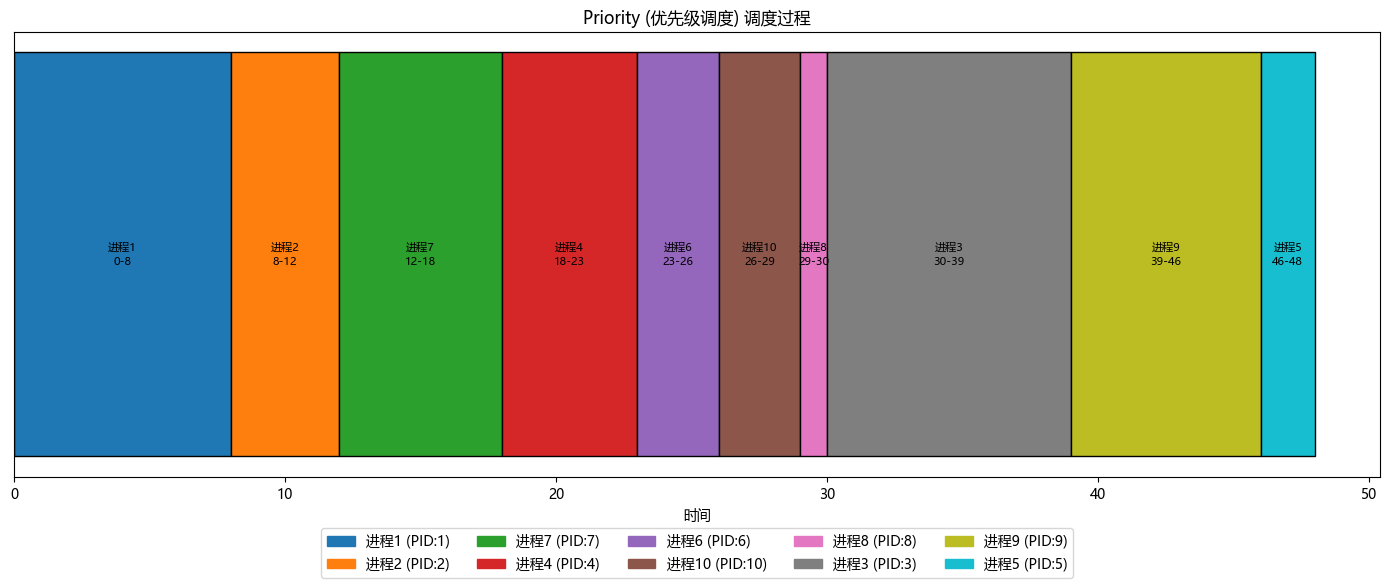


--- RR (时间片轮转, 时间片=2) 调度结果 ---
+--------+--------+----------+----------+----------+----------+----------+--------------+
| 进程ID | 进程名 | 到达时间 | 服务时间 | 开始时间 | 完成时间 | 周转时间 | 带权周转时间 |
+--------+--------+----------+----------+----------+----------+----------+--------------+
|   5    | 进程5  |    4     |    2     |    10    |    12    |    8     |     4.00     |
|   2    | 进程2  |    1     |    4     |    2     |    14    |    13    |     3.25     |
|   8    | 进程8  |    7     |    1     |    20    |    21    |    14    |    14.00     |
|   6    | 进程6  |    5     |    3     |    14    |    30    |    25    |     8.33     |
|   1    | 进程1  |    0     |    8     |    0     |    38    |    38    |     4.75     |
|   10   | 进程10 |    9     |    3     |    25    |    39    |    30    |    10.00     |
|   4    | 进程4  |    3     |    5     |    8     |    40    |    37    |     7.40     |
|   7    | 进程7  |    6     |    6     |    16    |    42    |    36    |     6.00     |
|   3    | 进程3  |    2   

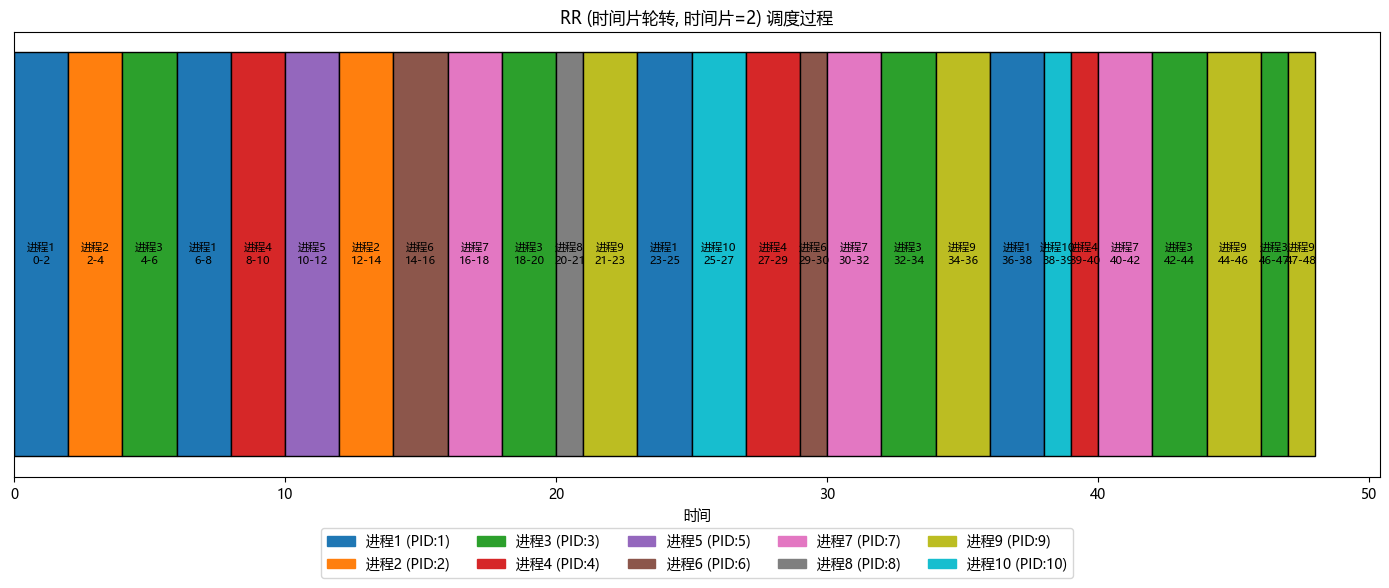

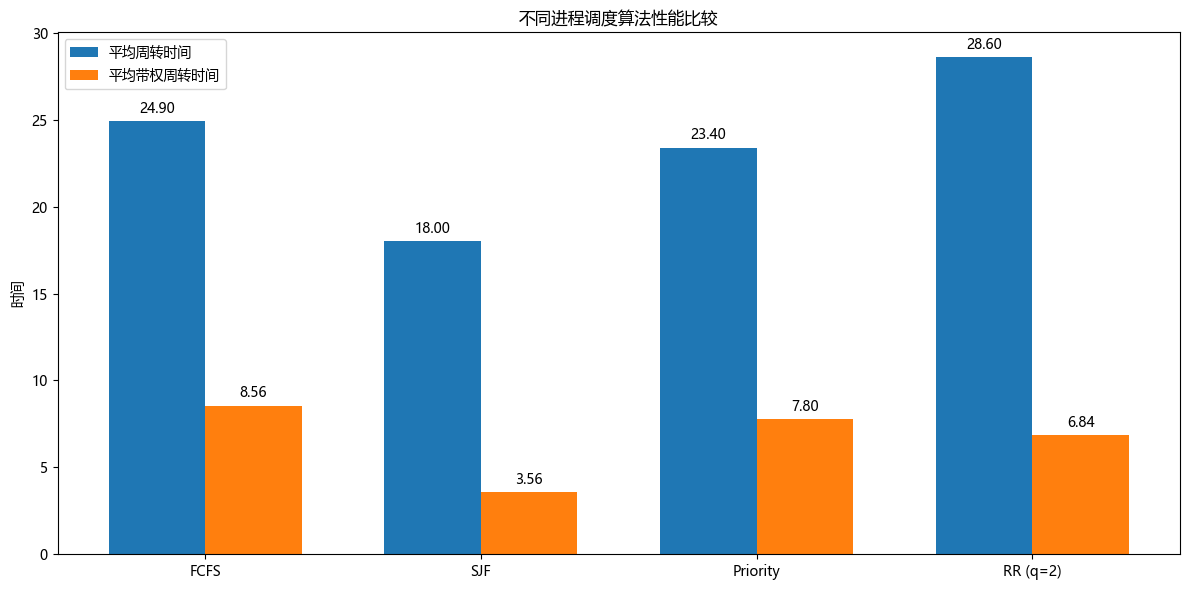


--- 各算法性能定性评价 ---
1. FCFS (先来先服务):
   - 优点: 实现简单，对长作业有利
   - 缺点: 对短作业不公平，平均等待时间可能较长

2. SJF (短作业优先):
   - 优点: 可以获得最小的平均等待时间和平均周转时间
   - 缺点: 可能导致长作业饥饿，且难以准确预估执行时间

3. Priority (优先级调度):
   - 优点: 可根据进程重要性进行调度，灵活性高
   - 缺点: 可能导致低优先级进程饥饿，需要考虑优先级反转问题

4. RR (时间片轮转):
   - 优点: 响应时间短，适合交互系统，公平性好
   - 缺点: 上下文切换开销大，平均周转时间较长


In [10]:
# 创建测试用例
def run_test():
    # 创建一组测试进程
    processes = [
        PCB(1, "进程1", 0, 8, 3),
        PCB(2, "进程2", 1, 4, 1),
        PCB(3, "进程3", 2, 9, 4),
        PCB(4, "进程4", 3, 5, 2),
        PCB(5, "进程5", 4, 2, 5),
        PCB(6, "进程6", 5, 3, 2),
        PCB(7, "进程7", 6, 6, 1),
        PCB(8, "进程8", 7, 1, 3),
        PCB(9, "进程9", 8, 7, 4),
        PCB(10, "进程10", 9, 3, 2)
    ]
    
    # 初始化调度器
    scheduler = Scheduler(processes)
    
    # 运行不同调度算法
    results = {}
    
    # 先来先服务
    results["FCFS"] = scheduler.fcfs()
    print_detailed_results("FCFS (先来先服务)", results["FCFS"], scheduler.execution_log)
    plot_gantt_chart("FCFS (先来先服务)", scheduler.execution_log)
    
    # 短作业优先
    results["SJF"] = scheduler.sjf()
    print_detailed_results("SJF (短作业优先)", results["SJF"], scheduler.execution_log)
    plot_gantt_chart("SJF (短作业优先)", scheduler.execution_log)
    
    # 优先级调度
    results["Priority"] = scheduler.priority()
    print_detailed_results("Priority (优先级调度)", results["Priority"], scheduler.execution_log)
    plot_gantt_chart("Priority (优先级调度)", scheduler.execution_log)
    
    # 时间片轮转(时间片=2)
    results["RR (q=2)"] = scheduler.round_robin(2)
    print_detailed_results("RR (时间片轮转, 时间片=2)", results["RR (q=2)"], scheduler.execution_log)
    plot_gantt_chart("RR (时间片轮转, 时间片=2)", scheduler.execution_log)
    
    # 可视化比较结果
    visualize_results(results)
    
    # 定性评价
    print("\n--- 各算法性能定性评价 ---")
    print("1. FCFS (先来先服务):")
    print("   - 优点: 实现简单，对长作业有利")
    print("   - 缺点: 对短作业不公平，平均等待时间可能较长")
    
    print("\n2. SJF (短作业优先):")
    print("   - 优点: 可以获得最小的平均等待时间和平均周转时间")
    print("   - 缺点: 可能导致长作业饥饿，且难以准确预估执行时间")
    
    print("\n3. Priority (优先级调度):")
    print("   - 优点: 可根据进程重要性进行调度，灵活性高")
    print("   - 缺点: 可能导致低优先级进程饥饿，需要考虑优先级反转问题")
    
    print("\n4. RR (时间片轮转):")
    print("   - 优点: 响应时间短，适合交互系统，公平性好")
    print("   - 缺点: 上下文切换开销大，平均周转时间较长")

# 执行测试
run_test()